# Классификация текстов с помощью рекуррентных и сверточных сетей

### Простая сеть LSTM

In [2]:
import numpy as np 
import pandas as pd
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
data = pd.read_csv('uci-news-aggregator.csv')

https://yadi.sk/d/B5WfVUrFnQXaEg

In [5]:
# Подсчитываем количество образцов каждого класса
data.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [6]:
data['LABEL'] = 0

In [7]:
data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,LABEL
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698,0
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207,0
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550,0
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793,0
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027,0


In [8]:
data.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [10]:
#One-hot encode the class
data.loc[data['CATEGORY'] == 'e', 'LABEL'] = 0
data.loc[data['CATEGORY'] == 'b', 'LABEL'] = 1
data.loc[data['CATEGORY'] == 't', 'LABEL'] = 2
data.loc[data['CATEGORY'] == 'm', 'LABEL'] = 3
labels = to_categorical(data['LABEL'], num_classes=4)
if 'CATEGORY' in data.keys():
    data.drop(['CATEGORY'], axis=1)
'''
 [1. 0. 0. 0.] e
 [0. 1. 0. 0.] b
 [0. 0. 1. 0.] t
 [0. 0. 0. 1.] m
'''

'\n [1. 0. 0. 0.] e\n [0. 1. 0. 0.] b\n [0. 0. 1. 0.] t\n [0. 0. 0. 1.] m\n'

In [11]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['TITLE'].values)
sequences = tokenizer.texts_to_sequences(data['TITLE'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 75583 unique tokens.


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42)

In [13]:
epochs = 10
emb_dim = 128
batch_size = 256


In [14]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()


((316814, 130), (316814, 4), (105605, 130), (105605, 4))
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 1,073,668
Trainable params: 1,073,668
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

C:\Users\Admin\.conda\envs\tensorflow-37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 253451 samples, validate on 63363 samples
Epoch 1/10
253451/253451 [==============================] - 127s 501us/step - loss: 0.3510 - acc: 0.8713 - val_loss: 0.2094 - val_acc: 0.9268
Epoch 2/10
253451/253451 [==============================] - 135s 533us/step - loss: 0.1984 - acc: 0.9302 - val_loss: 0.1982 - val_acc: 0.9294
Epoch 3/10
253451/253451 [==============================] - 136s 536us/step - loss: 0.1812 - acc: 0.9353 - val_loss: 0.1943 - val_acc: 0.9318
Epoch 4/10
253451/253451 [==============================] - 136s 538us/step - loss: 0.1703 - acc: 0.9385 - val_loss: 0.1938 - val_acc: 0.9317
Epoch 5/10
253451/253451 [==============================] - 136s 537us/step - loss: 0.1617 - acc: 0.9414 - val_loss: 0.1937 - val_acc: 0.9326
Epoch 6/10
253451/253451 [==============================] - 136s 536us/step - loss: 0.1548 - acc: 0.9434 - val_loss: 0.1941 - val_acc: 0.9328
Epoch 7/10
253451/253451 [==============================] - 136s 535us/step - loss: 0.1483 - acc:

In [16]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

105605/105605 [==============================] - 76s 718us/step
Test set
  Loss: 0.197
  Accuracy: 0.934


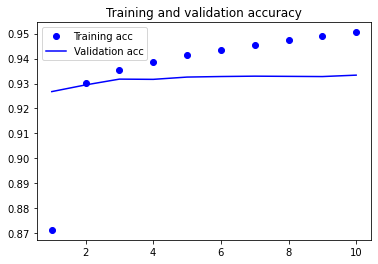

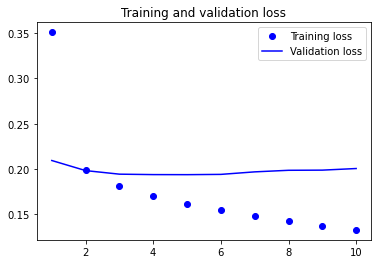

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
def detect_class(texts):
    labels = ['entertainment', 'bussiness', 'science/tech', 'health']
    for txt in texts:
        seq = tokenizer.texts_to_sequences([txt])
        padded = pad_sequences(seq, maxlen=max_len)
        pred = model.predict(padded)
        print(labels[np.argmax(pred)])

In [19]:
# Business
texts = \
['The Fed chair wants US lawmakers to approve even more stimulus spending. Will anyone listen?',
'For the second straight year, America is trailing other countries in the clean energy race',
'Energy drink? A UK startup is turning coffee into fuel',
'After years without turning a profit, Tesla is now poised to be a powerhouse',
'UK economy shrank by a record 5.8% in March. Much more pain is to come',
'This is the most expensive time to buy US stocks in 20 years',
'Virgin Australia still needs a buyer. Queensland state is making a bid',
'JCPenney execs get bonuses before deadline for possible bankruptcy filing',
'US grocery prices soar as almost everything else gets cheaper',
'Cloud ETFs are all the rage as more people work from home',
'Google Chrome will soon allow users to group their tabs together',
'French law requires social media to delete some content within an hour',
'Condé Nast lays off 100 staff, BuzzFeed cuts back in UK and Australia',
'Fox News dumps coronavirus coverage for anti-Obama conspiracy theory']

detect_class(texts)


bussiness
bussiness
science/tech
bussiness
bussiness
bussiness
bussiness
bussiness
bussiness
science/tech
science/tech
science/tech
bussiness
health


In [20]:
# Health
texts = \
["Yet another study shows hydroxychloroquine doesn't work against Covid-19",
"Doctors face 'nearly an impossible situation' as they ration remdesivir",
"It can still be hard to get a coronavirus test -- and that's not the only problem",
"Organ transplantations dropped sharply during coronavirus pandemic, study finds",
"Black light experiment shows how quickly a virus like Covid-19 can spread at a restaurant",
"Coronavirus may 'never go away,' says WHO official",
"DO NOT USE/Coronavirus safety measures create challenges for hard-of-hearing.",
"Pandemic safety measures can be difficult for hard-of-hearing. Here's how to help",
"Education leaders ask what's next as nearly all states ease coronavirus restrictions",
"Expect more cases of strange coronavirus syndrome in kids, doctors warn",
"How much water do we really need to drink?",
"From migraines to asthma to shingles: The physical toll coronavirus-related stress takes on your body and how to combat it"]

detect_class(texts)

health
health
health
health
health
health
health
health
health
health
bussiness
health


In [21]:
# Entertainment
texts = \
["Tony Shalhoub reveals that he and his wife have recovered from coronavirus",
"Network TV announces fall schedules, but with as many questions as answers",
"'Unbreakable Kimmy Schmidt' breaks in interactive comedy",
"Livestreams to watch from the couch this week",
"Bryan Adams apologizes for social media post blaming 'bat eating' people for coronavirus",
"Alison Roman pens apology to Chrissy Teigen and Marie Kondo",
"John Krasinski and 'The Office' costars recreated that wedding dance for a virtual ceremony",
"Tallulah Willis didn't speak to mom Demi Moore for three years",
"Nelly and Ludacris to headline the next Verzuz battle on Instagram Live",
"Jerry Stiller made us love him by screaming at us",
"'13 Reasons Why' cast does emotional table read for series finale",
"Kevin Hart and wife Eniko share gender reveal for baby No. 2",
"R&B lost three legends this weekend in Little Richard, Andre Harrell and Betty Wright",
"'I Know This Much is True' casts Mark Ruffalo as troubled twins with a dark family history"]

detect_class(texts)

health
entertainment
entertainment
entertainment
health
entertainment
entertainment
entertainment
science/tech
entertainment
entertainment
entertainment
entertainment
entertainment


In [22]:
# Tech

texts = \
["Elon Musk’s Boring Company finishes digging Las Vegas tunnels",
"Zipcar will now let you access a car within minutes of signing up for the service",
"Razer will use face mask vending machines to distribute millions of face masks in Singapore",
"Amazon asks Congress to make an anti-price gouging law",
"Moxie is a $1,500 robot for kids",
"How to buy a Nintendo Switch",
"Amazon adds a new ‘free’ section to Fire TV main menu",
"Samsung’s Galaxy A51 has two good things going for it: the screen and the price",
"Apple’s new MacBook Pro 13-inch has the keyboard we’ve been waiting for",
"Microsoft’s new Surface Go 2 has a bigger display and better Intel processor",
"Donald Trump extends Huawei ban through May 2021",
"Kickstarter loses nearly 40 percent of its workforce after layoffs and buyouts",
"Uber’s response to COVID-19: face masks, selfies, and fewer people in the car",
"Google is adding a tab grouping feature to Chrome for browser hoarders",
"Former astronaut and SpaceX consultant on creating a new crewed spacecraft: ‘We were really the underdogs’",
"Temperatures Soar To Highest Of The Year, it’s already getting too hot and humid in some places for humans to survive",
"Record-breaking astronaut Christina Koch on making space history and surviving lengthy isolation"]

detect_class(texts)

bussiness
science/tech
bussiness
science/tech
science/tech
science/tech
entertainment
entertainment
science/tech
science/tech
science/tech
science/tech
bussiness
science/tech
science/tech
science/tech
entertainment


### Bidirectional LSTM

In [23]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 1,123,332
Trainable params: 1,123,332
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(X_train, y_train, 
                    epochs=6, 
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

C:\Users\Admin\.conda\envs\tensorflow-37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 253451 samples, validate on 63363 samples
Epoch 1/6
253451/253451 [==============================] - 274s 1ms/step - loss: 0.3558 - acc: 0.8696 - val_loss: 0.2087 - val_acc: 0.9277
Epoch 2/6
253451/253451 [==============================] - 282s 1ms/step - loss: 0.1992 - acc: 0.9305 - val_loss: 0.1991 - val_acc: 0.9298
Epoch 3/6
253451/253451 [==============================] - 282s 1ms/step - loss: 0.1816 - acc: 0.9351 - val_loss: 0.1967 - val_acc: 0.9319
Epoch 4/6
253451/253451 [==============================] - 282s 1ms/step - loss: 0.1697 - acc: 0.9389 - val_loss: 0.1958 - val_acc: 0.9314
Epoch 5/6
253451/253451 [==============================] - 283s 1ms/step - loss: 0.1620 - acc: 0.9414 - val_loss: 0.1949 - val_acc: 0.9322
Epoch 6/6
253451/253451 [==============================] - 282s 1ms/step - loss: 0.1553 - acc: 0.9432 - val_loss: 0.1951 - val_acc: 0.9323


In [26]:
accuracy = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

105605/105605 [==============================] - 125s 1ms/step
Test set
  Loss: 0.193
  Accuracy: 0.933


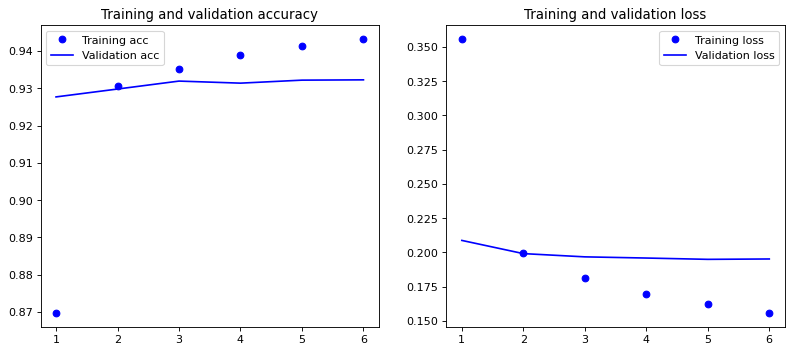

In [25]:
plt.figure(figsize=(12, 5), dpi=80)

plt.subplot(1,2,1)
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Одномерная сверточная сеть

In [31]:
from keras.layers import Conv1D, MaxPooling1D, Flatten
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(Conv1D(32, 3, activation='relu', input_shape=(None, emb_dim)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 128, 32)           12320     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 64, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 60, 64)            10304     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 15364     
Total params: 1,061,988
Trainable params: 1,061,988
Non-trainable params: 0
____________________________________________

In [32]:
history = model.fit(X_train, y_train, 
                    epochs=6, 
                    batch_size=batch_size,
                    validation_split=0.2)

C:\Users\Admin\.conda\envs\tensorflow-37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 253451 samples, validate on 63363 samples
Epoch 1/6
253451/253451 [==============================] - 15s 60us/step - loss: 0.3471 - acc: 0.8667 - val_loss: 0.2087 - val_acc: 0.9281
Epoch 2/6
253451/253451 [==============================] - 15s 60us/step - loss: 0.1747 - acc: 0.9386 - val_loss: 0.1990 - val_acc: 0.9296
Epoch 3/6
253451/253451 [==============================] - 16s 63us/step - loss: 0.1376 - acc: 0.9507 - val_loss: 0.2039 - val_acc: 0.9304
Epoch 4/6
253451/253451 [==============================] - 16s 63us/step - loss: 0.1022 - acc: 0.9634 - val_loss: 0.2205 - val_acc: 0.9299
Epoch 5/6
253451/253451 [==============================] - 16s 62us/step - loss: 0.0719 - acc: 0.9744 - val_loss: 0.2635 - val_acc: 0.9270
Epoch 6/6
253451/253451 [==============================] - 16s 63us/step - loss: 0.0520 - acc: 0.9820 - val_loss: 0.3152 - val_acc: 0.9253


In [33]:
accuracy = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

105605/105605 [==============================] - 10s 97us/step
Test set
  Loss: 0.310
  Accuracy: 0.925


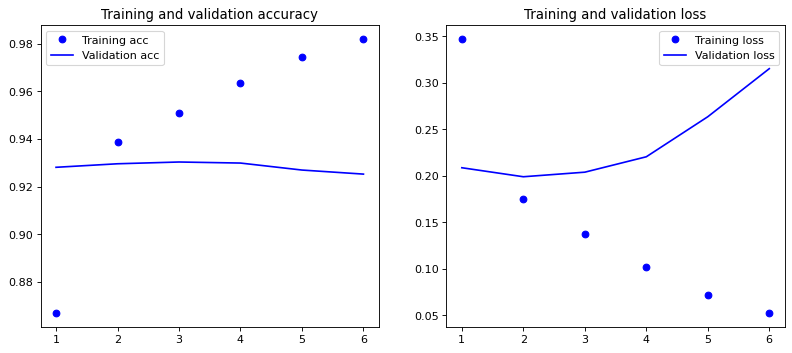

In [34]:
plt.figure(figsize=(12, 5), dpi=80)

plt.subplot(1,2,1)
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()